In [51]:
import numpy as np
import pandas as pd
import os
import math
import pickle

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import GenericUnivariateSelect, RFECV, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

In [153]:
# loading in preprocessed data
current_directory = os.getcwd()
CD_rev_train = pd.read_json(os.path.join(current_directory, 'full_preprocessed.json'))
#review_training_df = pd.read_json(os.path.join(current_directory, 'training_preprocessed.json'))
review_training_df = pd.read_json(os.path.join(current_directory, 'training_preprocessed_scaled.json'))

In [32]:
# adding all review text to preprocessed data for tfidf
reviewText = CD_rev_train.groupby('asin')['reviewText'].agg(lambda x: ' '.join(x)).reset_index()
summaryText = CD_rev_train.groupby('asin')['summary'].agg(lambda x: ' '.join(x)).reset_index()

reviewText.rename(columns={"reviewText":"joinedReviews"}, inplace=True)
summaryText.rename(columns={"summary":"joinedSummary"}, inplace=True)

review_training_df = pd.merge(review_training_df, reviewText, on='asin', how = 'left')
review_training_df = pd.merge(review_training_df, summaryText, on='asin', how = 'left')

In [13]:
# length of summary
CD_rev_train['sum_word_count'] = CD_rev_train['summary'].str.split().apply(len)
sum_word_count = CD_rev_train.groupby('asin')['sum_word_count'].mean()
sum_word_count = sum_word_count.values.reshape(-1,1)
review_training_df['summ_word_count'] = sum_word_count

In [17]:
# max verified
num_verified = CD_rev_train.groupby('asin')['verified'].sum()
num_verified = num_verified.values.reshape(-1, 1)
review_training_df['num_verified'] = num_verified

In [19]:
review_training_df.head(4)

,reviewerID,vote,verified,unixReviewTime,rev_Sentiment,summ_Sentiment,rev_compSentiment,summ_compSentiment,rev_posSentiment,summ_posSentiment,...,summToRev,normalized_time,max_upvote,av_word_count,total_reviews,norm_time_diff,joinedReviews,joinedSummary,summ_word_count,num_verified
0,4,1.500000,0.500000,933552000,1,1,0.892900,0.362375,0.548250,0.380000,...,0.719729,0.710932,6,43.250000,4,7.732503,even tho love album problem playing stereo sys...,love nancy five star beautiful legend nancy wi...,3.250000,2
1,18,2.500000,0.166667,983836800,1,1,0.682206,0.190683,0.272444,0.275333,...,0.707811,1.491616,22,120.611111,18,8.080412,musical genre core struggle pleasure repetitio...,struggle pleasure king progressive house digwe...,2.944444,3
2,4,1.250000,0.750000,1040342400,1,0,0.716600,-0.081925,0.420000,0.131000,...,0.534822,2.368880,5,70.000000,4,5.904968,great made mistake buying album listening neve...,five star bad business fun album legendary duo...,2.250000,3
3,29,2.862069,0.586207,1001030400,1,0,0.658507,0.258576,0.451897,0.303552,...,0.758861,1.758551,37,41.551724,29,7.769054,bob marley best else need said like reggae nee...,bob marley best else need said excellent quali...,3.137931,17


In [18]:
review_training_df.columns.to_list()

['reviewerID',
 'vote',
 'verified',
 'unixReviewTime',
 'rev_Sentiment',
 'summ_Sentiment',
 'rev_compSentiment',
 'summ_compSentiment',
 'rev_posSentiment',
 'summ_posSentiment',
 'rev_negSentiment',
 'summ_negSentiment',
 'image',
 'asin',
 'awesomeness',
 'rev_posNegRatio',
 'summ_posNegRatio',
 'summToRev',
 'normalized_time',
 'max_upvote',
 'av_word_count',
 'total_reviews',
 'norm_time_diff',
 'joinedReviews',
 'joinedSummary',
 'summ_word_count',
 'num_verified']

In [20]:
review_training_df.to_json(r'/Users/IanShi/Desktop/Classwork/CS 349/INDIVIDUAL FINAL/training_preprocessed.json')

In [3]:
tfidf = TfidfVectorizer()

In [37]:
tf_review = tfidf.fit_transform(review_training_df['joinedReviews'])

tf_summary = tfidf.fit_transform(review_training_df['joinedSummary'])

## Classification with new features

In [154]:
features = review_training_df.columns.to_list()
features.remove('asin')
features.remove('awesomeness')
features.remove('joinedReviews')
features.remove('joinedSummary')

In [141]:
features

['reviewerID',
 'vote',
 'verified',
 'rev_Sentiment',
 'summ_Sentiment',
 'rev_compSentiment',
 'summ_compSentiment',
 'rev_posSentiment',
 'summ_posSentiment',
 'rev_negSentiment',
 'summ_negSentiment',
 'image',
 'rev_posNegRatio',
 'summ_posNegRatio',
 'summToRev',
 'normalized_time',
 'max_upvote',
 'av_word_count',
 'total_reviews',
 'norm_time_diff',
 'summ_word_count',
 'num_verified']

In [155]:
X = review_training_df[features]
Y = review_training_df['awesomeness']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

### Random Forest

In [156]:
# grid search for RF
param_grid = {"n_estimators": [x for x in range(1,50)], "max_depth": [x for x in range(1,5)]}
forest = RandomForestClassifier(n_jobs=-1)
f_gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=1)
f_gs = f_gs.fit(X_train, Y_train)
forest_pred = f_gs.predict(X_test)
f_gs.best_params_

Fitting 5 folds for each of 196 candidates, totalling 980 fits


{'max_depth': 1, 'n_estimators': 49}

In [157]:
rf_estimator = RandomForestClassifier(n_estimators = 49, max_depth = 1, n_jobs=-1)
rf_selector = RFECV(estimator = rf_estimator, scoring = 'f1', step = 1, cv = 5, verbose = 2)
rf_selector = rf_selector.fit(X_train, Y_train)
rf_selector.ranking_

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [158]:
rf = RandomForestClassifier(n_estimators = 48, max_depth = 1, n_jobs=-1)
rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)

# model accuracy
print("Random Forest Accuracy:",metrics.accuracy_score(Y_test, rf_pred))
forest_cv = cross_val_score(rf, X, Y, cv = 10, scoring='f1')
print("Mean CV F1 Score:", np.mean(forest_cv))
print("Standard Deviation F1 Score:", np.std(forest_cv))

Random Forest Accuracy: 0.5717673888255416
Mean CV F1 Score: 0.6808475166810475
Standard Deviation F1 Score: 0.008304232076693


              precision    recall  f1-score   support

           0       0.60      0.28      0.38     10234
           1       0.57      0.83      0.68     11691

    accuracy                           0.58     21925
   macro avg       0.58      0.56      0.53     21925
weighted avg       0.58      0.58      0.54     21925



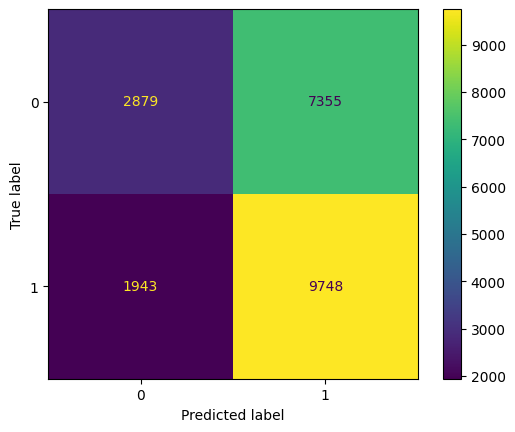

In [27]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, rf_pred))

### Decision Tree

In [159]:
param_grid = {"max_depth": [x for x in range(1,20)]}
tree = DecisionTreeClassifier()
tree_gs = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=2)
tree_gs = tree_gs.fit(X_train, Y_train)
treegs_pred = tree_gs.predict(X_test)
tree_gs.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=1; total time=   0.1s
[CV] END ........................................max_depth=2; total time=   0.2s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=2; total time=   0.3s
[CV] END ........................................max_depth=3; total time=   0.4s
[CV] END .......................................

{'max_depth': 4}

In [160]:
# feature picking for tree
tree_estimator = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)
tree_selector = RFECV(estimator = tree_estimator, scoring = 'f1', step = 1, cv = 5, verbose = 2)
tree_selector = tree_selector.fit(X_train, Y_train)
tree_selector.ranking_

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.


array([ 1, 11,  1,  8,  7,  6,  5,  1, 12,  4,  1,  1,  3,  1,  2,  1,  1,
        9, 10,  1,  1, 13, 14])

In [77]:
features

['reviewerID',
 'vote',
 'verified',
 'unixReviewTime',
 'rev_Sentiment',
 'summ_Sentiment',
 'rev_compSentiment',
 'summ_compSentiment',
 'rev_posSentiment',
 'summ_posSentiment',
 'rev_negSentiment',
 'summ_negSentiment',
 'image',
 'rev_posNegRatio',
 'summ_posNegRatio',
 'summToRev',
 'normalized_time',
 'max_upvote',
 'av_word_count',
 'total_reviews',
 'norm_time_diff',
 'summ_word_count',
 'num_verified']

In [161]:
tree_features = list(['reviewerID', 'verified', 'rev_negSentiment', 'summ_negSentiment', 'rev_posNegRatio',
                     'normalized_time', 'norm_time_diff'])
tX = review_training_df[features]
tY = review_training_df['awesomeness']
tX_train, tX_test, tY_train, tY_test = train_test_split(tX, tY, test_size = 0.3, random_state = 1)

In [162]:
# decision tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
tree = tree.fit(tX_train, tY_train)
tree_pred = tree.predict(tX_test)

# model accuracy
print("Decision Tree Accuracy:",metrics.accuracy_score(tY_test, tree_pred))

# 10 fold cross validation
tree_cv = cross_val_score(tree, tX, tY, cv = 10, scoring='f1')
print("Mean CV F1 Score:", np.mean(tree_cv))
print("Standard Deviation F1 Score:", np.std(tree_cv))

Decision Tree Accuracy: 0.5849030786773091
Mean CV F1 Score: 0.6637211180210006
Standard Deviation F1 Score: 0.008650713212425751


              precision    recall  f1-score   support

           0       0.58      0.39      0.47     10234
           1       0.59      0.76      0.66     11691

    accuracy                           0.59     21925
   macro avg       0.59      0.57      0.56     21925
weighted avg       0.59      0.59      0.57     21925



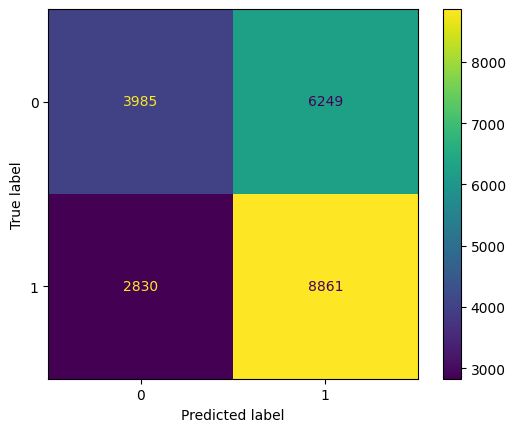

In [92]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, tree_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, tree_pred))

### Logistic Regression

In [163]:
# logit
log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X_train, Y_train)
lg_pred = log_reg.predict(X_test)

# model accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test, lg_pred))

# 10 fold cross validation
lg_cv = cross_val_score(log_reg, X, Y, cv = 10, scoring='f1')
print("Mean CV F1 Score:", np.mean(lg_cv))
print("Standard Deviation F1 Score:", np.std(lg_cv))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.5937970353477765


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Mean CV F1 Score: 0.6577786443223546
Standard Deviation F1 Score: 0.005020188981208363


### Late Fusion

              precision    recall  f1-score   support

           0       0.59      0.39      0.47     10234
           1       0.59      0.76      0.66     11691

    accuracy                           0.59     21925
   macro avg       0.59      0.57      0.56     21925
weighted avg       0.59      0.59      0.57     21925



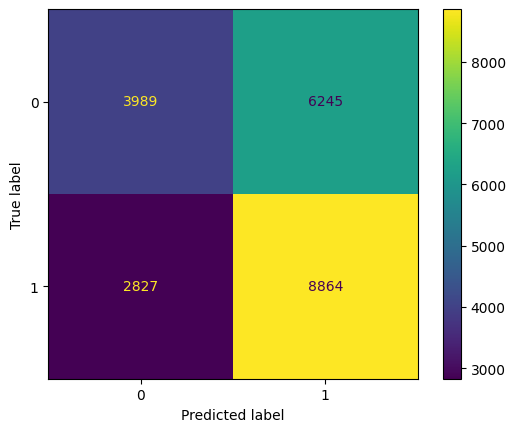

In [165]:
estimators=[('rf', rf), ('tree', tree)]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X_train, Y_train)
lf_pred = ensemble.predict(X_test)
labels = ["0", "1"]
cm = confusion_matrix(Y_test, lf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, lf_pred))

## TFIDF ONLY

In [28]:
features = review_training_df.columns.to_list()
features.remove('asin')
features.remove('awesomeness')

X = review_training_df[features]
Y = review_training_df['awesomeness']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

### Pipeline

In [ ]:
rf_pipe = RandomForestClassifier(n_jobs = -1)
mlp = MLPClassifier(solver = 'adam', hidden_layer_sizes=(256, 128, 64, 32), activation='relu', random_state=1)
col_transform = ColumnTransformer([('tfidf1', tfidf, 'joinedReviews'), ('tfidf2', tfidf, 'joinedSummary')], remainder='passthrough')

pipe = Pipeline([('tfidf', col_transform), ('classify', rf_pipe)])

pipe.fit(X_train, Y_train)

In [12]:
pickle.dump(pipe, open('tfidf.pkl', 'wb'))

In [36]:
pipe_pred = pipe.predict(X_test)

print("Pipe RF Accuracy:",metrics.accuracy_score(Y_test, pipe_pred))

Pipe RF Accuracy: 0.6130900798175599


In [ ]:
pipe_cv = cross_val_score(pipe, X, Y, cv = 2, scoring='f1')
print("Mean CV F1 Score:", np.mean(pipe_cv))
print("Standard Deviation F1 Score:", np.std(pipe_cv))

              precision    recall  f1-score   support

           0       0.61      0.47      0.53     10234
           1       0.61      0.74      0.67     11691

    accuracy                           0.61     21925
   macro avg       0.61      0.60      0.60     21925
weighted avg       0.61      0.61      0.61     21925



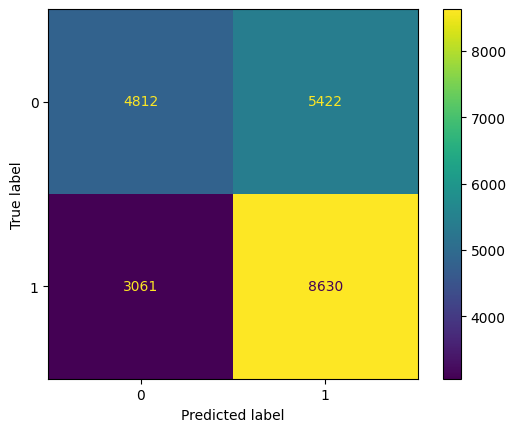

In [37]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, pipe_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, pipe_pred))

### Logistic Regression

In [46]:
features = ['joinedReviews']
X = review_training_df['joinedReviews']
Y = review_training_df['awesomeness']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

Train:  (51157,) (51157,) Test:  ((21925,), (21925,))


In [48]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(X_train)
tf_test = tfidf.transform(X_test)

logit = LogisticRegression(max_iter=1000)

logit.fit(tf_train, Y_train)
logit_pred = logit.predict(tf_test)

              precision    recall  f1-score   support

           0       0.60      0.53      0.56     10234
           1       0.63      0.69      0.66     11691

    accuracy                           0.62     21925
   macro avg       0.62      0.61      0.61     21925
weighted avg       0.62      0.62      0.62     21925



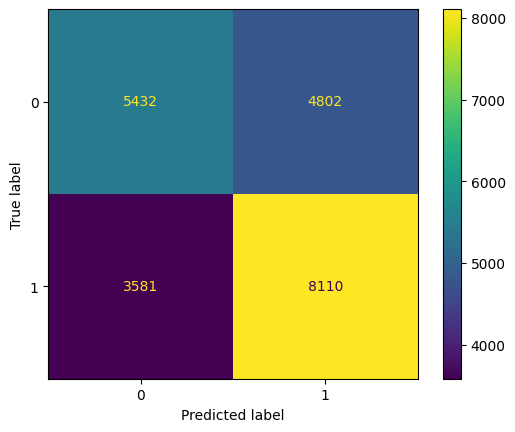

In [50]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, logit_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, logit_pred))

### SVC

In [52]:
svc = LinearSVC(random_state=0)
svc.fit(tf_train, Y_train)
svc_pred = svc.predict(tf_test)

              precision    recall  f1-score   support

           0       0.57      0.53      0.55     10234
           1       0.61      0.65      0.63     11691

    accuracy                           0.59     21925
   macro avg       0.59      0.59      0.59     21925
weighted avg       0.59      0.59      0.59     21925



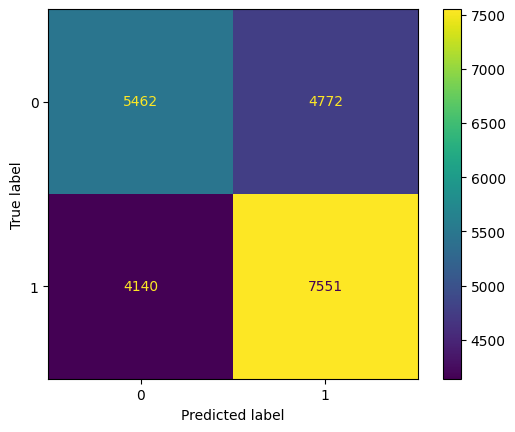

In [54]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, svc_pred))

### Random Forest w/ Hyperparam Optimization

In [56]:
param_grid = {"n_estimators": [x for x in range(1,50)], "max_depth": [x for x in range(1,6)]}
forest = RandomForestClassifier(n_jobs=-1)
f_gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5, verbose=2)
f_gs = f_gs.fit(tf_train, Y_train)
forest_pred = f_gs.predict(tf_test)
f_gs.best_params_

Fitting 5 folds for each of 245 candidates, totalling 1225 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   9.2s
[CV] END ........................max_depth=1, n_estimators=1; total time=   9.8s
[CV] END ........................max_depth=1, n_estimators=2; total time=   9.8s
[CV] END ........................max_depth=1, n_estimators=1; total time=   9.9s
[CV] END ........................max_depth=1, n_estimators=2; total time=   9.9s
[CV] END ........................max_depth=1, n_estimators=1; total time=   9.9s
[CV] END ........................max_depth=1, n_estimators=1; total time=   9.9s
[CV] END ........................max_depth=1, n_estimators=2; total time=  10.2s
[CV] END ........................max_depth=1, n_estimators=2; total time=   2.5s
[CV] END ........................max_depth=1, n_estimators=2; total time=   2.7s
[CV] END ........................max_depth=1, n_estimators=3; total time=   2.8s
[CV] END ........................max_depth=1,

{'max_depth': 2, 'n_estimators': 48}

In [61]:
rf = RandomForestClassifier(n_estimators = 48, max_depth = 2, n_jobs=-1)
rf.fit(tf_train, Y_train)
rf_pred = rf.predict(tf_test)

              precision    recall  f1-score   support

           0       0.66      0.03      0.06     10234
           1       0.54      0.99      0.70     11691

    accuracy                           0.54     21925
   macro avg       0.60      0.51      0.38     21925
weighted avg       0.59      0.54      0.40     21925



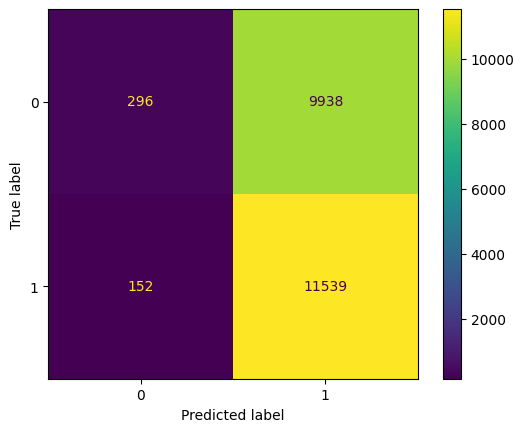

In [62]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, rf_pred))

### Decision Tree w/ Hyperparam Optimization

In [64]:
param_grid = {"max_depth": [x for x in range(1,16)]}
tree = DecisionTreeClassifier()
tree_gs = GridSearchCV(estimator=tree, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=4, verbose=2)
tree_gs = tree_gs.fit(tf_train, Y_train)
treegs_pred = tree_gs.predict(tf_test)
tree_gs.best_params_

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV] END ........................................max_depth=1; total time=  17.3s
[CV] END ........................................max_depth=1; total time=  17.5s
[CV] END ........................................max_depth=1; total time=  17.9s
[CV] END ........................................max_depth=1; total time=  18.0s
[CV] END ........................................max_depth=2; total time=  20.5s
[CV] END ........................................max_depth=2; total time=  20.7s
[CV] END ........................................max_depth=2; total time=  20.8s
[CV] END ........................................max_depth=2; total time=  20.9s
[CV] END ........................................max_depth=3; total time=  20.2s
[CV] END ........................................max_depth=3; total time=  20.2s
[CV] END ........................................max_depth=3; total time=  20.3s
[CV] END .......................................

{'max_depth': 3}

In [65]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth = 3)
tree = tree.fit(tf_train, Y_train)
tree_pred = tree.predict(tf_test)

              precision    recall  f1-score   support

           0       0.56      0.28      0.38     10234
           1       0.56      0.80      0.66     11691

    accuracy                           0.56     21925
   macro avg       0.56      0.54      0.52     21925
weighted avg       0.56      0.56      0.53     21925



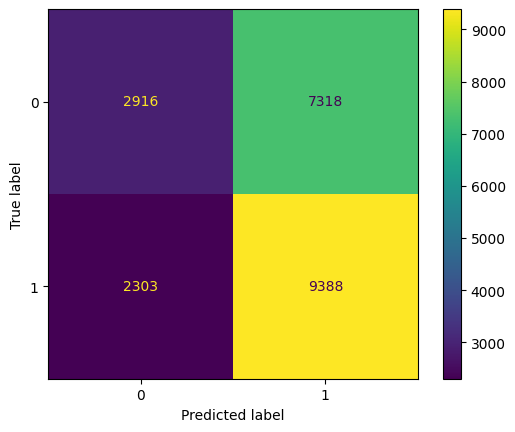

In [66]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, tree_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, tree_pred))

### Late Fusion

In [67]:
estimators=[('rf', rf), ('tree', tree), ('log', logit)]
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(tf_train, Y_train)
lf_pred = ensemble.predict(tf_test)

              precision    recall  f1-score   support

           0       0.63      0.41      0.50     10234
           1       0.61      0.79      0.69     11691

    accuracy                           0.61     21925
   macro avg       0.62      0.60      0.59     21925
weighted avg       0.62      0.61      0.60     21925



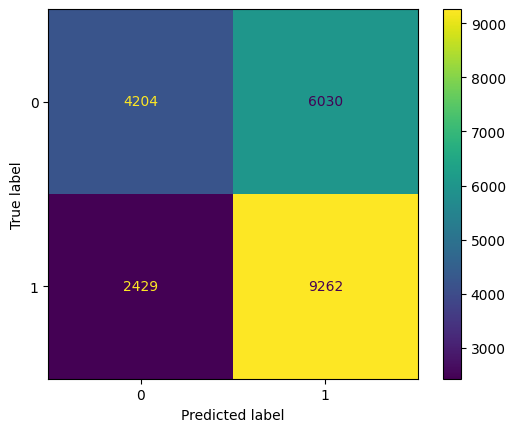

In [68]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, lf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, lf_pred))

## Pipeline

In [145]:
features = review_training_df.columns.to_list()
features.remove('asin')
features.remove('unixReviewTime')
features.remove('awesomeness')

X = review_training_df[features]
Y = review_training_df['awesomeness']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [101]:
tfidf = TfidfVectorizer()
rf_pipe = RandomForestClassifier(n_jobs = -1)
mlp = MLPClassifier()
col_transform = ColumnTransformer([('tfidf1', tfidf, 'joinedReviews'), ('tfidf2', tfidf, 'joinedSummary')], remainder='passthrough')

pipe = Pipeline([('tfidf', col_transform), ('clf', rf_pipe)])

#pipe.fit(X_train, Y_train)

In [102]:
param_grid = {"clf__n_estimators": [x for x in range(1,30)], "clf__max_depth": [x for x in range(1,4)]}
pipe_gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=4, verbose=1)
pipe_gs = pipe_gs.fit(X_train, Y_train)
pipe_gs.best_params_

Fitting 4 folds for each of 87 candidates, totalling 348 fits


{'clf__max_depth': 2, 'clf__n_estimators': 27}

In [148]:
tfidf = TfidfVectorizer()
#rf_pipe = RandomForestClassifier(n_estimators = 27, max_depth = 2, n_jobs = -1)
rf_pipe = RandomForestClassifier(n_jobs=-1)
mlp = MLPClassifier()
col_transform = ColumnTransformer([('tfidf1', tfidf, 'joinedReviews'), ('tfidf2', tfidf, 'joinedSummary')], remainder='passthrough')

pipe = Pipeline([('tfidf', col_transform), ('clf', rf_pipe)])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf1', TfidfVectorizer(),
                                                  'joinedReviews'),
                                                 ('tfidf2', TfidfVectorizer(),
                                                  'joinedSummary')])),
                ('clf', RandomForestClassifier(n_jobs=-1))])

              precision    recall  f1-score   support

           0       0.62      0.48      0.54     10234
           1       0.62      0.74      0.67     11691

    accuracy                           0.62     21925
   macro avg       0.62      0.61      0.61     21925
weighted avg       0.62      0.62      0.61     21925



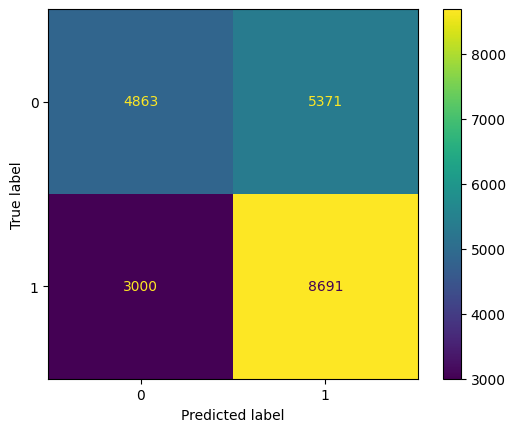

In [149]:
pipe_pred = pipe.predict(X_test)
labels = ["0", "1"]
cm = confusion_matrix(Y_test, pipe_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, pipe_pred))

## MLPClassifier

In [166]:
features = review_training_df.columns.to_list()
features.remove('asin')
features.remove('awesomeness')
features.remove('joinedReviews')
features.remove('joinedSummary')
test_features = list(['verified', 'rev_Sentiment'])
X = review_training_df[features]
Y = review_training_df['awesomeness']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [110]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (400, 200, 100, 50)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_estimator = MLPClassifier()
mlp_gs = GridSearchCV(estimator=mlp_estimator, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=2, verbose=1)
mlp_gs = mlp_gs.fit(X_train, Y_train)
mlp_gs.best_params_

Fitting 2 folds for each of 72 candidates, totalling 144 fits


{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'solver': 'sgd'}

In [167]:
mlp = MLPClassifier(activation='relu', alpha = 0.001, hidden_layer_sizes=(1024, 512, 256, 128), solver = 'adam')
mlp = mlp.fit(X_train,Y_train)
mlp_pred = mlp.predict(X_test)

print("MLP Accuracy:",metrics.accuracy_score(Y_test, mlp_pred))
# mlp_cv = cross_val_score(mlp, X, Y, cv = 5, scoring='f1')
# print("Mean CV F1 Score:", np.mean(mlp_cv))
# print("Standard Deviation F1 Score:", np.std(mlp_cv))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 0.5692588369441277


              precision    recall  f1-score   support

           0       0.55      0.43      0.48     10234
           1       0.58      0.69      0.63     11691

    accuracy                           0.57     21925
   macro avg       0.57      0.56      0.56     21925
weighted avg       0.57      0.57      0.56     21925



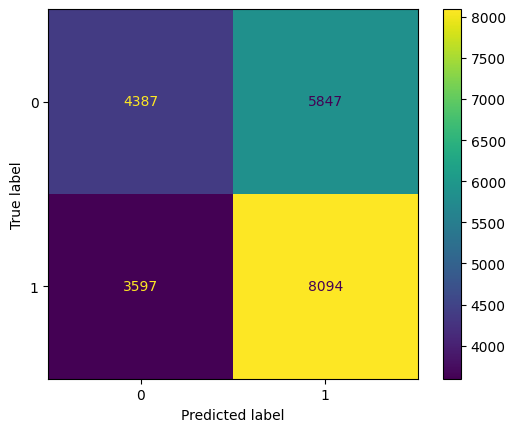

In [168]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, mlp_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, mlp_pred))